Notebook Link: https://colab.research.google.com/drive/1hgkyDQcXg-vYCocFJPUWA2jkb_GSsJak?usp=*sharing*

# BA810 - Team 1 Cohort B - Project: Loan Default Prediction

Team members: Luca Matteucci, Santiago Mazzei, Srithijaa Sankepally, and Victor Floriano


# 1 - Business problem definition and data description


---



1.0 - **Problem Statement:**

Our goal is to predict what customers are more likely to default on their loan payments. By analyzing the Lending Club Loan dataset, we aim to create a model that will predict to loan defaults and late payments. We want to make the lending process better, reduce default risk, and increase profitability for lenders.

1.1 - **Data Source:**

We will use the Lending Club Loan dataset, which includes complete loan data for loans issued from 2007 to 2015. The Lending Club is a peer-to-peer lending company that matches people looking to invest money with people looking to borrow money. The dataset provides information about borrowers, loan characteristics, and loan performance. The data is freely available on Kaggle at: https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv




1.2 - **Data Description:**

The dataset contains approximately 2,260,668 observations and 145 variables (columns). The variables include information, such as borrower characteristics (e.g., credit scores, income, employment details), loan characteristics (e.g., loan amount, interest rate, purpose), and loan performance data (e.g., current loan status, delinquency history). Some of the variables we expect to be useful for our analysis include: `annual_inc`, `loan_amnt`, `int_rate`, `delinq_2yrs`, `purpose`, among others.

The dataset contains multiple data types, including float64 (105 instances), int64 (4 instances), and object (36 instances). Additionally, it includes several variables that necessitate preprocessing, such as:
1. Binary values assigned to 'Y'/'N'. (i.e. `hardship_flag`)
2. Object columns would work better as datetime. (i.e. `settlement_date`)
3. Variables with text input. (i.e. `desc`)

#2 - Import libraries, load the data, and sample from the original dataset


---
To avoid issues in our colab notebook, we decided to use a sample of the original data for train/test our models. Before moving to the next steps, make sure that the entire original dataset was loaded in the colab environment, the cell below with `loan_df.info()` should return DataFrame with 2,260,667 records.


In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [ ]:
#Create drive and load the original dataset
from google.colab import drive
drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/data-ba810-project/loan.csv')
df = pd.read_csv('/content/drive/MyDrive/BU_MSBA/BA810/Data/loan.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-1b7f31243c4f>:5: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/BU_MSBA/BA810/Data/loan.csv')


In [ ]:
#Display the number of entries, columns, and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


Our target variable contains multiple values, we will transform this column into a binary 0/1 variable. Additionally, records with `Current` outcomes are essentially loans for which we do not have labels yet. Therefore, we decided to remove those from our analysis.

In [ ]:
#Check distribution of target varible in the original dataset
print('Distribution of loan_status values in the original dataset:\n')
df['loan_status'].value_counts(normalize=True) * 100

Distribution of loan_status values in the original dataset:



Fully Paid                                             46.090448
Current                                                40.682444
Charged Off                                            11.574234
Late (31-120 days)                                      0.968608
In Grace Period                                         0.395989
Late (16-30 days)                                       0.165305
Does not meet the credit policy. Status:Fully Paid      0.087939
Does not meet the credit policy. Status:Charged Off     0.033663
Default                                                 0.001371
Name: loan_status, dtype: float64

In [ ]:
#Dropping records were the status of our target variable (loan_status)
#is Current

#Get index value for all rows where the loan_status = Current
row_indexes_drop = df[df['loan_status'] == 'Current'].index

#Drop selected rows
df.drop(row_indexes_drop, axis=0, inplace=True)

#Check if the Current values were dropped
df['loan_status'].value_counts(normalize=True) *100

Fully Paid                                             77.701192
Charged Off                                            19.512324
Late (31-120 days)                                      1.632919
In Grace Period                                         0.667575
Late (16-30 days)                                       0.278678
Does not meet the credit policy. Status:Fully Paid      0.148251
Does not meet the credit policy. Status:Charged Off     0.056750
Default                                                 0.002312
Name: loan_status, dtype: float64

To create a representative sample from our original dataset, we used the `train_test_split` method to create a stratified sample.

In [ ]:
#Split the data into a left_out portion and our stratified sample
left_out, sample_df = train_test_split(df, test_size=0.01,
                                       stratify=df['loan_status'],
                                       random_state=42)

sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13410 entries, 1760999 to 2100132
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 14.9+ MB


After creating our sample we check the distribution of loan_status to verify if it resembled the original dataset. While there was small difference in the distribution of loan_status values, the distribution is very similar to the original dataset.

In [ ]:
#Check loan_status distribution for sample_df
print('Distribution of loan_status values in the sample dataset:\n')
sample_df['loan_status'].value_counts(normalize=True) * 100

Distribution of loan_status values in the sample dataset:



Fully Paid                                             77.703207
Charged Off                                            19.515287
Late (31-120 days)                                      1.633110
In Grace Period                                         0.663684
Late (16-30 days)                                       0.275913
Does not meet the credit policy. Status:Fully Paid      0.149142
Does not meet the credit policy. Status:Charged Off     0.059657
Name: loan_status, dtype: float64

To clean RAM space in our Colab environment, we proceeded to remove the original dataset and the unused data

In [ ]:
#Remove original dataset and unused data
del df
del left_out
del row_indexes_drop

#Manually trigger garbage collection
gc.collect()

0

# 3 - Initial data exploration


---



In [ ]:
#Summary Statstics of selected varibles
sample_df[['annual_inc', 'loan_amnt', 'int_rate', 'delinq_2yrs']].describe()

,annual_inc,loan_amnt,int_rate,delinq_2yrs
count,1.341000e+04,13410.000000,13410.000000,13410.000000
mean,7.579384e+04,14482.690157,13.383148,0.318195
std,9.874761e+04,8737.793682,4.735920,0.893429
min,0.000000e+00,900.000000,5.310000,0.000000
25%,4.500000e+04,8000.000000,9.990000,0.000000
50%,6.500000e+04,12000.000000,12.990000,0.000000
75%,9.000000e+04,20000.000000,16.020000,0.000000
max,9.573072e+06,40000.000000,30.990000,20.000000


In [ ]:
#Correlation matrix of selected key variables
sample_df[['annual_inc', 'loan_amnt', 'int_rate', 'delinq_2yrs']].corr()

,annual_inc,loan_amnt,int_rate,delinq_2yrs
annual_inc,1.000000,0.219665,-0.055372,0.037186
loan_amnt,0.219665,1.000000,0.142629,0.016710
int_rate,-0.055372,0.142629,1.000000,0.052567
delinq_2yrs,0.037186,0.016710,0.052567,1.000000


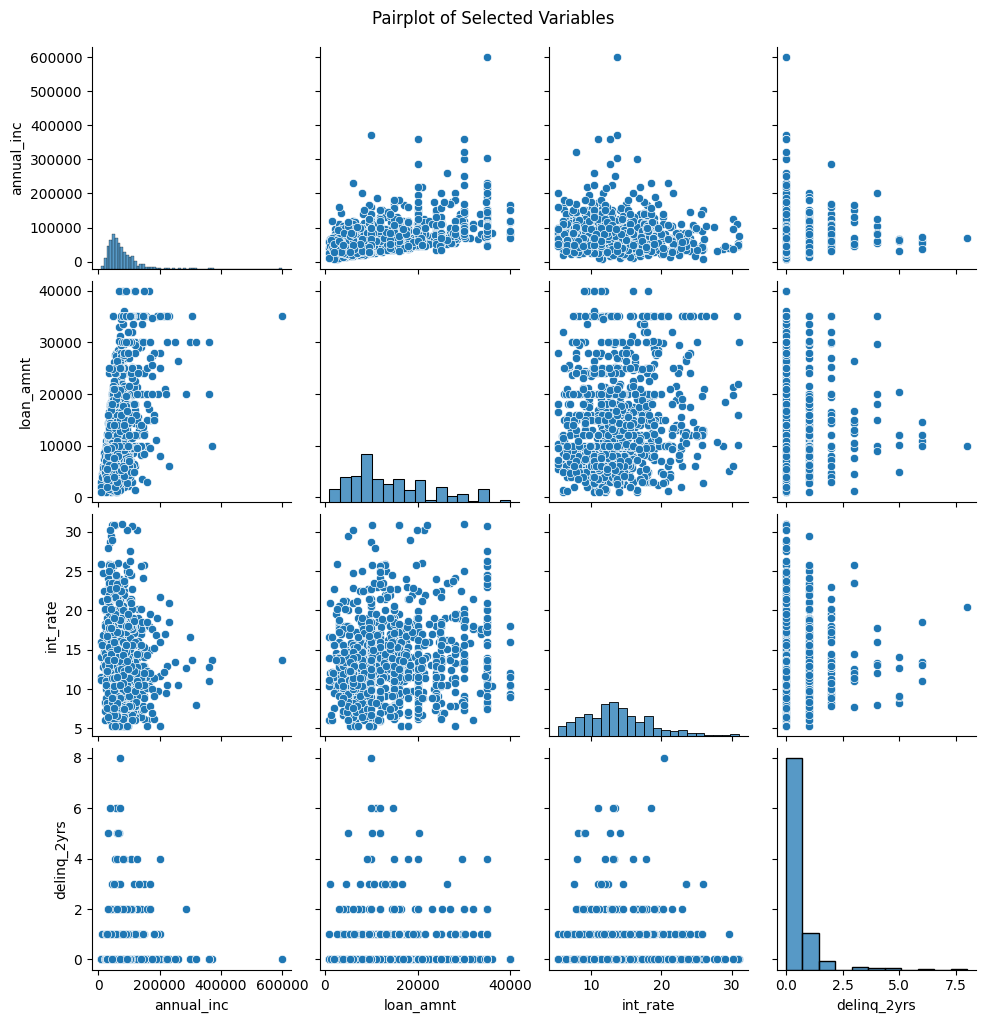

In [ ]:
#For the pairplot we had to select a smaller set of the database because
#using the entire dataset was making colab run out of RAM, so here we added
#the pairplot as an example of what we intend to do. In our project we will either
#use google cloud or work wil a smaller set of the original dataset.
loan_sample = sample_df[['annual_inc', 'loan_amnt', 'int_rate',\
                       'delinq_2yrs']].sample(1000, replace=False)

pairplot = sns.pairplot(loan_sample)
pairplot.fig.suptitle('Pairplot of Selected Variables', y=1.02);

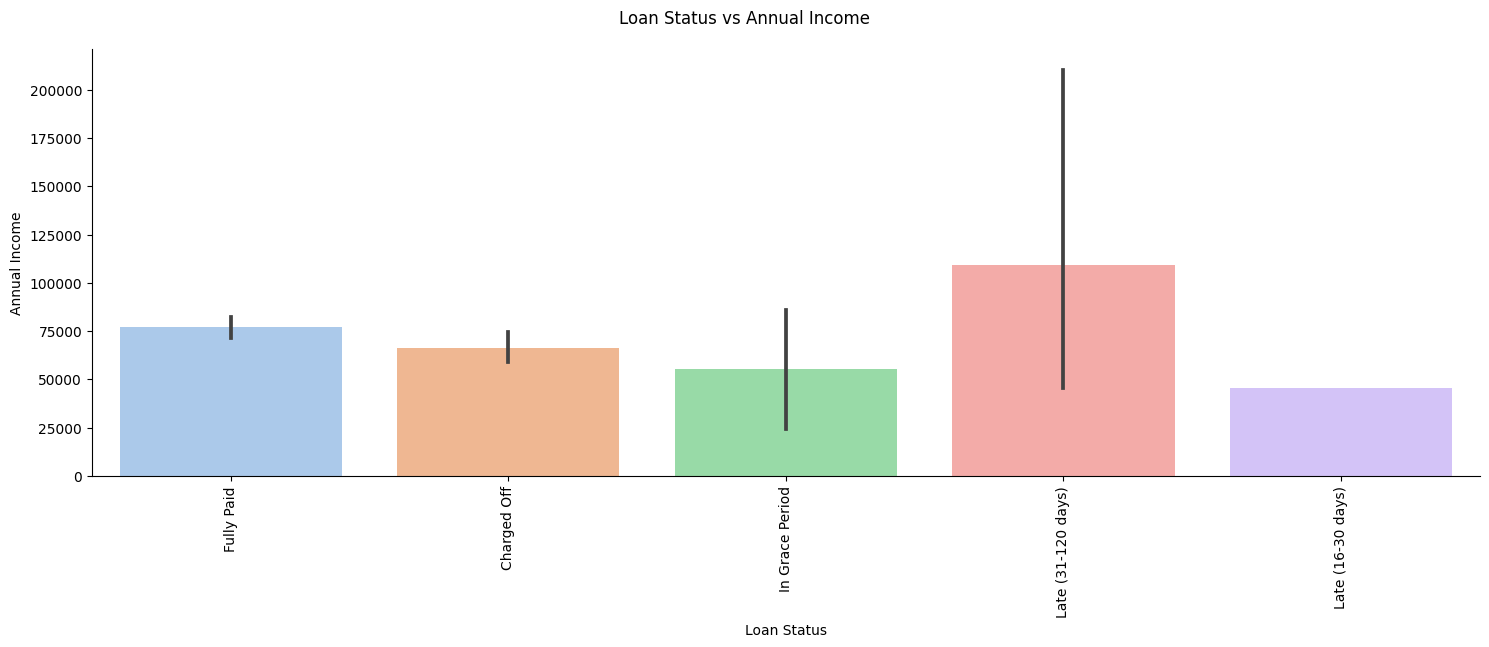

In [ ]:
#Graph of the Loan Status vs Annual Income

#Create a new sample of the data
loan_sample_2 = sample_df.sample(500, replace=False)

catplot = sns.catplot(kind = 'bar', x = 'loan_status',y = 'annual_inc', data = loan_sample_2, palette = 'pastel', aspect=3);
plt.suptitle('Loan Status vs Annual Income', y=1.05)
catplot.set_axis_labels('Loan Status', 'Annual Income')
catplot.set_xticklabels(rotation=90)
plt.show();

# 4 - Prepare Data Processing for Machine Learning


---


###4.1 - Drop columns with too many missing values

In our set on predictors, one issue was that a number of features had an excessive number of missing values, we decided to drop those columns.

1.  Among the various columns, `id` and `member_id` serve as unique identifiers. The `id` column is distinct for each loan record, while `member_id` uniquely identifies each borrower. Besides the extensive number of unique values, most data from these features was missing, so we dropped both columns.

2. For the remaining variables in our dataset, we adopted a threshold-based approach, deciding to eliminate any predictors where over 35% of the data was missing. Given the significant lack of available information for those predictors, imputations methods would yield untrustworthy results.
  * 58 columns had more than 35% of their data missing and were dropped from our analysis.

In [ ]:
#Create a Series with the % of missing values for each feature
missing_percent = sample_df.isnull().mean() * 100

#Select only columns with more than 35% of their data missing
#and extract the names of columns to be dropped
columns_to_drop = missing_percent[missing_percent>35.0].index

#Drop columns from sample_df
sample_df.drop(columns=columns_to_drop, inplace=True)

###4.2 - Description of Remaining Columns and Summary of Further Modifications:

Based on the descriptions of the columns, it appears that columns with numeric data should be processed as numerical values, and those labeled as 'object' columns as categoric. For some varibles additional steps were needed, and they are listed below:

* `loan_status` : Our TARGET varible, the status of the loan. While multiple values appeared in the data, we re-mapped those to (0 = no default) or (1 = default) | categoric
* `loan_amnt`: The listed amount of the loan applied for by the borrower | **numeric**
* `funded_amnt` : The total amount committed to that loan at that point in time | **numeric**
* `funded_amnt_inv` : NO DESCRIPTION FOUND, values also seem very similar to funded amount | **dropped**
* `term` : Number of payments on the loan. Values are in months and can be either 36 or 60, re-mapped to '30' and '60' (originally ' 30 months' and ' 60 months') | **categoric**
* `int_rate`: The effective interest rate is equal to the interest rate on a Note reduced by Lending Club's estimate of the impact of uncollected interest prior to charge off | **numeric**
* `installment` : The monthly payment owed by the borrower if the loan originates | **numeric**
* `grade`: LC assigned loan grade, values from 'A' to 'F'. | **categoric**
* `sub_grade`: LC assigned loan subgrade (i.e. 'A5')| **categoric**
* `emp_title`: The job title supplied by the Borrower when applying for the loan, too many unique values | **dropped**
* `emp_length`: Employment length in years. Possible values are between 0 and 10. 0 means less than one year and 10 means ten or more years. | **categoric**
* `home_ownership`:  The home ownership status provided by the borrower during registration | **categoric**
* `annual_inc`: The self-reported annual income provided by the borrower during registration | **numeric**
* `verification_status` : Income was verified by LC, not verified, or if the income source was verified | **categoric**
* `issue_d` : Date value in which the loan was issued. Changed to datetime and then converted into numeric value represnting the time since the earliest day in the dataset | **numeric**
* `issue_d_since`: Days since the earliest `issue_d` present in the dataset. It converts `issue_d` into a numeric variable | **numeric**
* `pymnt_plan` : Payment plan 'y' or 'n' | **categoric**
* `purpose`: A category provided by the borrower for the loan request(14 unique categories) | **categoric**
* `title`: Loan title provided by the borrower, a text based varible (+8k unique entries), since NLP is outside of the score of this project we dropped this feature | **dropped**
* `zip_code`
* `addr_state`: The state provided by the borrower in the loan application | **categoric**
* `dti`:  Ratio calculated of borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. | **numeric**
* `delinq_2yrs`: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years | **numeric**
* `earliesst_cr_line`: The date the borrower's earliest reported credit line was opened
* `inq_last_6mths`: The number of inquiries in the past 6 months.| **numeric**
* `open_acc`: The number of open credit lines.| **numeric**
* `pub_rec`: The number of derogatory public records.| **numeric**
* `revol_bal`: The total credit revolving balance.| **numeric**
* `revol_util`: The revolving line utilization rate.| **numeric**
* `total_acc`: The total number of credit lines.| **numeric**
* `initial_list_status`: The initial listing status of the loan. It has discrete values (W, F). Convert it to a categorical variable. | **categorical**
* `out_prncp`: The remaining outstanding principal for the total amount funded.| **numeric**
* `out_prncp_inv`: The remaining outstanding principal funded by investors.| **numeric**
* `total_pymnt`: The payments received to date for the total amount funded.| **numeric**
* `total_pymnt_inv`: The payments received to date for the portion funded by investors.| **numeric**
* `total_rec_prncp`: The principal received to date.| **numeric**
* `total_rec_int`: The interest received to date.| **numeric**
* `total_rec_late_fee`: The late fees received to date.| **numeric**
* `recoveries`: The post-charge-off gross recovery. Since any value besides 0 would already indicate that the customer class is 1 (default), we remmoved this variable (it would lead the models to 'cheat' on their predictions| **dropped**
* `collection_recovery_fee`: The post-charge-off collection fee. Since it indicates that the customer have already defaulted, and the loan was charged off, we decided to drop this variable| **dropped**
* `last_pymnt_d`: The last month/year payment was received. We converted the values into datetime, and then into the number of days since the loan was initially issues in which the last payment was made| **numeric**
* `last_pymnt_amnt`: The last total payment amount received.| **numeric**
* `last_credit_pull_d`: The most recent month credit was pulled. Convert it to a categorical variable.| **categorical**
* `collections_12_mths_ex_med`: The number of collections in the last 12 months excluding medical collections.| **numeric**
* `policy_code`: It has only two possible values, and it's not clear what do those values mean. It might not provide meaningful information.| **drop**
* `application_type`: Indicates whether the loan is an individual or joint application. Already object type.| **object**
* `acc_now_delinq`: The number of accounts on which the borrower is now delinquent. The values for this variable are 0, 1, 2, 3, 5, 14. | **numerical**
* `tot_coll_amt`: Total collection amounts ever owed | **numerical**
* `tot_cur_bal`: Total current balance of all accountsm | **numerical**
* `total_rev_hi_lim`: Total revolving (perpetual like credit cards) high credit limit | **numerical**
* `acc_open_past_24mths`: Number of account opened in past 24 months. | **numerical**
* `avg_cur_bal`: Average current balance of all accounts |**numerical**
* `bc_open_to_buy`: Total open to buy on revolving bankcards (amount open). | **numerical**
* `bc_util`: Ratio of total current balance to credit limit for all bankcard accounts. | **numerical**
* `chargeoff_within_12_mths`: Number of charge-offs (considered a loss by the lender but still obbligation) within 12 months |**numerical**
* `delinq_amnt`: The past-due amount owed for the accounts on which the borrower is now delinquent | **numerical**
* `mo_sin_old_il_acct`: (6% NULL) Months since oldest bank installment account opened | **numerical**
* `mo_sin_old_rev_tl_op`: Months since oldest revolving account opened | **numerical**  
* `mo_sin_rcnt_rev_tl_op`:Months since most recent revolving account opened | **numerical**
* `mo_sin_rcnt_tl`: Months since most recent account opened | **numerical**
* `mort_acc`: Number of mortgage accounts. | **numerical**
* `mths_since_recent_bc`: Months since most recent bankcard account opened. | **numerical**
* `mths_since_recent_inq`:(13% NULL) SHOULD BE THE REQUEST NOT NECESSARILY OPEN USUALLY > OF THE OTHERS VARIABLES Months since most recent inquiry. | **numerical**
* `num_accts_ever_120_pd`: Number of accounts over 120 or more days past due | **numerical**
* `num_actv_bc_tl`: Number of currently active bankcard accounts | **numerical**
* `num_actv_rev_tl`: Number of currently active revolving account | **numerical**
* `num_bc_sats`: Number of satisfactory (current or being paid) bankcard accounts | **numerical**
* `num_bc_tl`: Number of bankcard accounts | **numerical**
* `num_il_tl` : Number of installment accounts | **numeric**
* `num_op_rev_tl` : Number of open revolving accounts | **numeric**
* `num_rev_accts` : Number of revolving accounts | **numeric**
* `num_sats` : Number of satisfactory accounts | **numeric**
* `num_tl_120dpd_2m` : Number of accounts currently 120 days past due (updated in past 2 months) | **numeric**
* `num_tl_30dpd` : Number of accounts currently 30 days past due (updated in past 2 months) | **numeric**
* `num_tl_90g_dpd_24m` : Number of accounts 90 or more days past due in last 24 months | **numeric**
* `num_tl_op_past_12m` : Number of accounts opened in past 12 months | **numeric**
* `pct_tl_nvr_dlq` : Percent of trades never delinquent | **numeric**
* `percent_bc_gt_75` : Percentage of all bankcard accounts > 75% of limit | **numeric**
* `pub_rec_bankruptcies` : Number of public record bankruptcies | **numeric**
* `tax_liens` : Number of tax liens | **numeric**
* `tot_hi_cred_lim` : Total high credit/credit limit | **numeric**
* `total_bal_ex_mort` : Total credit balance excluding mortgage | **numeric**
* `total_bc_limit` : Total bankcard high credit/credit limit | **numeric**
* `total_il_high_credit_limit` : Total installment high credit/credit limit | **numeric**
* `hardship_flag` : Flags whether or not the borrower is on a hardship plan | **categorical**
* `disbursement_method` : The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY | **categorical**
* `debt_settlement_flag` : Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company. Since it indicates that the customer has defaulted on the current loan we decided to drop it | **dropped**




In [ ]:
#Check for unique values
sample_df['term'].unique()

#Re-mapping values
sample_df['term'].replace({' 36 months':'36', ' 60 months':'60'}, inplace=True)

In [ ]:
#When checking the possible values for emp_title we
#found that in our sample of around 200k records, there
#are more than 80k unique values, this would create problems when
#splitting the data and could over complicate our models, so
#we decided to drop this predictor.
print(sample_df['emp_title'].value_counts())

#Drop predictor
sample_df.drop(columns=['emp_title'], inplace=True)

Teacher                    210
Manager                    202
Owner                      106
Registered Nurse            90
Sales                       76
                          ... 
FCS GROUP                    1
Assistant Ombudsman, IV      1
Starbucks                    1
Electrician Apprentice       1
Guidant Group, Inc.          1
Name: emp_title, Length: 7944, dtype: int64


`issue_d`, `last_pymnt_d`, and `last_credit_pull_d` all had a similar issue, they were all object-type varibles with many unique values resenting different dates in the format MM-YYYY. Since `issue_d` represented the time when the loan was issued, we converted both `last_pymnt_d`, and `last_credit_pull_d` into numeric varibles representing how many days since the loan was issued it took for each event to happen. At the end we also converyed `issue_d` into a numeric varible to keep the ordinal component between values.

In [ ]:
#issue_d is the date the loan was funded.
#Too many unique values, it would slow down our models too much. However, since
#there is an ordinal component to the dates we decided to convert them into
#numeric
print(sample_df['issue_d'].unique())

#Convert the columns into datetime dtype
sample_df['issue_d'] = pd.to_datetime(sample_df['issue_d'], format='%b-%Y')

#Select the earliest date
earliest_issue_d = sample_df['issue_d'].min()

#Change values to represent the days since the earliest date on record
sample_df['issue_d_since'] = (sample_df['issue_d'] - earliest_issue_d).dt.days


['Jun-2013' 'Nov-2015' 'Jul-2015' 'Mar-2017' 'Dec-2013' 'Dec-2015'
 'Mar-2016' 'Aug-2017' 'Nov-2016' 'Jan-2018' 'Oct-2014' 'Jul-2013'
 'Oct-2015' 'Jun-2015' 'Nov-2012' 'Jul-2012' 'Apr-2014' 'Mar-2015'
 'Dec-2014' 'Apr-2017' 'May-2015' 'May-2016' 'May-2014' 'Apr-2015'
 'Dec-2016' 'Sep-2012' 'Jan-2015' 'Jan-2016' 'Feb-2014' 'Apr-2016'
 'Sep-2015' 'Sep-2016' 'Aug-2015' 'Aug-2013' 'Jan-2017' 'Dec-2010'
 'Jun-2014' 'Jun-2017' 'Mar-2014' 'Nov-2013' 'Oct-2016' 'May-2017'
 'Sep-2013' 'Jul-2016' 'Jul-2018' 'Nov-2018' 'Feb-2016' 'Jun-2016'
 'Jul-2014' 'Aug-2016' 'Dec-2017' 'Oct-2010' 'Jul-2017' 'Mar-2013'
 'Sep-2014' 'Feb-2018' 'Nov-2014' 'Nov-2017' 'Jan-2014' 'Jun-2018'
 'Aug-2010' 'Feb-2013' 'Sep-2017' 'Feb-2015' 'May-2011' 'Aug-2011'
 'Dec-2012' 'Feb-2008' 'Aug-2012' 'Apr-2013' 'May-2013' 'Feb-2017'
 'Aug-2014' 'Oct-2013' 'May-2012' 'Oct-2012' 'Oct-2017' 'Dec-2011'
 'Apr-2012' 'Apr-2018' 'Jun-2012' 'Feb-2012' 'May-2010' 'Jul-2011'
 'May-2018' 'Feb-2009' 'Mar-2011' 'Aug-2008' 'Dec-2018' 'Jan-2

In [ ]:
#last_pymnt_d indicates the month-year in which the a payment
#was made. Since we have the date in which the loan was issued, we converted this
#predictor into the number of days since the loan was issued in which the last
#payment was made
print(sample_df['last_pymnt_d'])

#Convert the column into datetime dtype
sample_df['last_pymnt_d'] = pd.to_datetime(sample_df['last_pymnt_d'], format='%b-%Y')

#Change values to represent the days since the loan was issued
sample_df['last_pymnt_d'] = (sample_df['last_pymnt_d'] - sample_df['issue_d']).dt.days
print('After Conversion:\n', sample_df['last_pymnt_d'])

1760999    May-2015
989071     Jan-2018
1137726    Oct-2016
1358479    Jun-2017
1001859    Mar-2018
             ...   
2070278    Jun-2014
2097010    Nov-2014
538046     Nov-2016
480586     Mar-2018
2100132    Feb-2014
Name: last_pymnt_d, Length: 13410, dtype: object
After Conversion:
 1760999    699.0
989071     792.0
1137726    458.0
1358479     92.0
1001859    851.0
           ...  
2070278    120.0
2097010    304.0
538046      92.0
480586      59.0
2100132    793.0
Name: last_pymnt_d, Length: 13410, dtype: float64


In [ ]:
#last_credit_pull_d indicates the last month/year in which credit was pulled.
#Since we have the date in which the loan was issued, we converted this
#predictor into the number of days since the loan was issued in which the last
#credit pull occured
print(sample_df['last_credit_pull_d'])

#Convert the column into datetime dtype
sample_df['last_credit_pull_d'] = pd.to_datetime(sample_df['last_credit_pull_d'], format='%b-%Y')

#Change values to represent the days since the loan was issued
sample_df['last_credit_pull_d'] = (sample_df['last_credit_pull_d'] - sample_df['issue_d']).dt.days
print('After Conversion:\n', sample_df['last_credit_pull_d'])

1760999    Feb-2019
989071     Jan-2018
1137726    Feb-2019
1358479    Nov-2018
1001859    Feb-2019
             ...   
2070278    Oct-2016
2097010    Feb-2019
538046     Feb-2019
480586     Mar-2018
2100132    Mar-2014
Name: last_credit_pull_d, Length: 13410, dtype: object
After Conversion:
 1760999    2071.0
989071      792.0
1137726    1311.0
1358479     610.0
1001859    1188.0
            ...  
2070278     973.0
2097010    1857.0
538046      914.0
480586       59.0
2100132     821.0
Name: last_credit_pull_d, Length: 13410, dtype: float64


In [ ]:
#issue_d was kept so we could convert last_pymnt_d and last_credit_d,
#after converting those two predictors we dropped issue_d since we have its
#transformed version, issue_d_since in the dataset

#Drop predictor
sample_df.drop(columns=['issue_d'], inplace=True)

In [ ]:
#Loan status has multiple different values.
#For simplicity re-map to either default or no default
print(sample_df['loan_status'].unique())


sample_df['loan_status'].replace({ 'Fully Paid':0,
                                  'Charged Off':1, 'Late (31-120 days)':1,
                                  'In Grace Period':0, 'Does not meet the credit policy. Status:Fully Paid':0,
                                  'Late (16-30 days)':1, 'Does not meet the credit policy. Status:Charged Off':1,
                                  'Default':1
}, inplace=True)

['Charged Off' 'Fully Paid' 'Late (31-120 days)' 'In Grace Period'
 'Late (16-30 days)' 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


After mapping `loan_status` values to 0 and 1 we also checked the resulting class balance. Since our minority class represents 21% of the data, we decided that class balance is not a severe issue.

In [ ]:
#Checking class balance:

sample_df['loan_status'].value_counts(normalize=True)

0    0.78516
1    0.21484
Name: loan_status, dtype: float64

In [ ]:
#recoveries would already tell the models that the customer is from class 1 (default)
#so we decided to drop it

sample_df.drop(columns=['recoveries'], inplace=True)

In [ ]:
#collections recovery fee had the same issue, it would indicate that the customer
#had already defaulted, so we decided to drop it

sample_df.drop(columns=['collection_recovery_fee'], inplace=True)

In [ ]:
#debt_settlement_flag would also flag customers that were charged-off on their
#current loan, so we decided to drop this predictor

sample_df.drop(columns=['debt_settlement_flag'], inplace=True)

In [ ]:
sample_df['loan_status'].value_counts()

0    10529
1     2881
Name: loan_status, dtype: int64

In [ ]:
#Check title feature
#title seems to contain explanations that the
#borrower provided for the loan, or simply 'thank you'
#messages (unstructured data). Given that NLP is outside of the scope of this
#project we decided to drop this feature
print(sample_df['title'].value_counts())

sample_df.drop(columns=['title'], inplace=True)

Debt consolidation         6629
Credit card refinancing    2418
Home improvement            744
Other                       662
Major purchase              211
                           ... 
Credit consolidate            1
Happy Days                    1
Honda CBX                     1
September 2011 Loan           1
Citi Gone                     1
Name: title, Length: 1157, dtype: int64


In [ ]:
#Too many unique values - Dropped
len(sample_df['zip_code'].unique())

sample_df.drop(columns=['zip_code'], inplace=True)

In [ ]:
#Too many unique values, did not seem as relevant as issue_d (DROP)
sample_df['earliest_cr_line'].unique()

sample_df.drop(columns=['earliest_cr_line'], inplace=True)

In [ ]:
#Change initial_list_status to categoric
sample_df['initial_list_status'].astype('object')


1760999    w
989071     w
1137726    f
1358479    w
1001859    f
          ..
2070278    f
2097010    w
538046     w
480586     f
2100132    f
Name: initial_list_status, Length: 13410, dtype: object

In [ ]:
#Drop policy code variable (unavailable information on variable)

sample_df.drop(columns=['policy_code'], inplace=True)

###4.3 - Create Train/Test Split

In [ ]:
#Train/test split
X = sample_df.drop('loan_status', axis=1)
y = sample_df['loan_status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0, stratify=y)

#Create copies to experiment on before adding to pipeline
X_train_copy = X_train.copy();
y_train_copy = y_train.copy();

###4.4 - Imputation of Null Values

After removing the features with more than 35% missing values, some predictors still contained some null values. We decided to test SimpleImputer, a method that will later be applied in our pre-processing pipeline (SECTION X)


In [ ]:
#Note: test will be done on numeric columns
#Create mean imputer
mean_imputer = SimpleImputer(strategy="mean")

#Select only numerical variables
X_train_copy_num = X_train_copy.select_dtypes(include=[np.number])

#Fit/Transform
X_train_copy_imp = mean_imputer.fit_transform(X_train_copy_num)

#Create dataframe with results
X_train_copy_imp_df = pd.DataFrame(X_train_copy_imp, columns=X_train_copy_num.columns, index=X_train_copy_num.index)

#Check for any null values remaining
print('Missing values remaining (numeric cols):', X_train_copy_imp_df.isnull().sum().sum())


Missing values remaining (numeric cols): 0


###4.4 - Feature Scaling

To prepare our data for models that require normalized values, we tested feature scaling in this section before applying it on our pre-processing pipeline

In [ ]:
#Create standard scaler object
std_scaler = StandardScaler()

#Fit/Transform
X_train_copy_num_std_scaled = std_scaler.fit_transform(X_train_copy_num)

#Create dataframe with results
X_train_copy_num_std_scaled_df = pd.DataFrame(X_train_copy_num_std_scaled, columns=X_train_copy_num.columns, index=X_train_copy_num.index)
X_train_copy_num_std_scaled_df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_d_since
1695369,-0.566591,-0.565684,-0.562048,-1.556186,-0.570636,-0.193459,0.342258,-0.357752,-0.694272,0.079734,...,-1.195405,0.664327,0.110075,-0.356598,-0.140507,-0.607780,-0.069705,-0.304051,0.236153,-0.951601
758114,-1.084582,-1.083790,-1.079792,-0.408708,-1.043134,-0.164607,-0.838438,0.781109,-0.694272,-1.561727,...,-0.647879,-0.973069,-1.274842,-0.356598,-0.140507,-0.843956,-0.809705,-0.848483,-0.437535,0.410760
2024936,1.010403,1.011660,1.014198,1.019310,0.580983,-0.164607,0.406811,-0.357752,-0.694272,0.262118,...,0.447173,-0.480705,-0.086583,-0.356598,-0.140507,-0.687542,-0.307749,-0.328141,-0.200679,-0.651616
1040846,2.368690,2.370248,2.371839,-0.893855,2.570844,-0.010733,0.115281,-0.357752,-0.694272,-0.467420,...,-0.647879,0.664327,-0.720875,-0.356598,-0.140507,-0.438998,0.339708,1.656867,-0.438690,0.206903
1433242,1.698180,1.699589,1.701648,0.333777,2.173518,0.624001,-0.967544,-0.357752,-0.694272,1.356426,...,0.994699,0.664327,1.032431,2.298684,-0.140507,-0.524427,0.522779,0.100659,0.303409,0.965981


#5 - Pre-Processing


---

##5.1 - Create Pre-Processing Pipeline

We create a pre-processing pipeline that will dig into the variables separeting between categorical and numerical.
For the numerical we use a standard scaler as well a simple imputer who substitute the null value with the median. For the categorical ones we use the one hot encoder strategy and fill in null values with the most frequent.

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram')

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) #ingore unknown cateogry
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
])

prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])

## 5.2 - Testing Feature selection

For our feature selection we tested both SelectKBest and RFECV. Due to the high dimensionality of our data RFECV proved to be too comutationally demanding, even with a sample of our data. Therefore, we decided to use the SelectKBest method.

Note: The steps we took to train our REFCV model can be found in the Appendix Section, we commented out the code to reduce the run time of the full notebook.

In [ ]:
#Runtime ~ 3min (1% data)
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import warnings

#Suppress warnings in this cell, otherwise it will give a warning that unknown
#categories were found
warnings.filterwarnings('ignore')

kbest = SelectKBest(score_func=f_classif) #ANOVA F-value for the provided sample/Had to change the score_func to remove error
k_best_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', kbest),
    ('model', LogisticRegression(max_iter=1000))
])


param_grid = {
    'select__k':range(1, 50) #Lower list of k values selected to improve runtime
}

grid_search = GridSearchCV(k_best_pipe, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)


# Examine the results
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(cv_res.filter(regex = '(^param_|mean_test_score)', axis=1))

#Re-enables warnings
warnings.filterwarnings('default')

,param_select__k,mean_test_score
43,44,0.931162
42,43,0.931162
47,48,0.930906
40,41,0.930818
44,45,0.930276
46,47,0.930251
45,46,0.930251
38,39,0.930227
41,42,0.930225
39,40,0.930006


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, "Performance of Different 'K' Variables in SelectKBest")

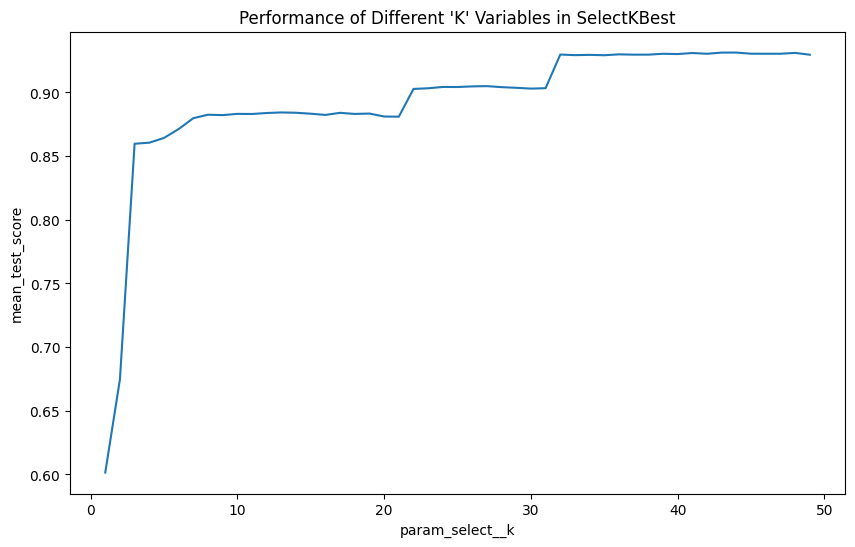

In [ ]:
plt.figure(figsize=(10, 6))

df_select_k_best_results = pd.DataFrame(cv_res.filter(regex = '(^param_|mean_test_score)', axis=1))

sns.lineplot(data=df_select_k_best_results, x='param_select__k', y='mean_test_score')

plt.title("Performance of Different 'K' Variables in SelectKBest")

##5.3 - Full Pre-Processing Pipeline

We decided to use the SelectKBest with 25 features in our full pipeline

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
kbest = SelectKBest(score_func=f_classif, k=25) #ANOVA F-value for the provided sample/Had to change the score_func to remove error
full_pipeline = Pipeline([
    ('prep', prep_pipeline),
    ('select', kbest)
])

full_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                ('select', SelectKBest(k=25))])

#6 - Predictive Models


---



In [ ]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##6.1 - K-Nearest Neighbors - KNN


---

For our KNN model we tested the folowing:

1. Baseline model
    * All parameters at default values
    * F1-score:  0.770
2. Hypeparameter Tuning - Grid Search CV:
  * Iterated over different parameter values for `n_neighbors` and `weights`
  * Best F1-score: 0.780

3. Hypeparameter Tuning - Radomized Search CV:
  * Iterated over different parameter values for `n_neighbors` and `weights`
  * Best F1-score: 0.770

4. From the Grid Search method we found that the best values for the searched hyper-parameters are:
  * `n_neighbors`: 10
  * `weights`: 'distance'

  With a F1-score of: 0.780

Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset

###Baseline KNN Model

In [ ]:
#KNN (20sec - 5%)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Instanciate KNN model pipeline - all default params
knn_pipe = make_pipeline(full_pipeline, KNeighborsClassifier(n_neighbors=5,
                                                            n_jobs=-1))

#Evaluate the baseline model with CV
knn_pipe_cv_results = cross_validate(knn_pipe, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)


#Print the results
print(f'Average Baseline KNN model Cross-Validation accuracy: {np.mean(knn_pipe_cv_results["test_accuracy"])}')
print(f'Average Baseline KNN model Cross-Validation precision: {np.mean(knn_pipe_cv_results["test_precision"])}')
print(f'Average Baseline KNN model Cross-Validation recall: {np.mean(knn_pipe_cv_results["test_recall"])}')
print(f'Average Baseline KNN model Cross-Validation F1-score: {np.mean(knn_pipe_cv_results["test_f1"])}')

Average Baseline KNN model Cross-Validation accuracy: 0.909675615212528
Average Baseline KNN model Cross-Validation precision: 0.848211770962784
Average Baseline KNN model Cross-Validation recall: 0.7054458351394306
Average Baseline KNN model Cross-Validation F1-score: 0.7701803741588237


###Grid Search - KNN

In [ ]:
#Tuning KNN (3m29sec - 5%)
from sklearn.model_selection import GridSearchCV

knn_params = {'kneighborsclassifier__n_neighbors': [2,5,10,15,20,25,30],
              'kneighborsclassifier__weights':['uniform','distance']
              }

knn_grid_search = GridSearchCV(estimator=knn_pipe, param_grid=knn_params,
                               scoring='f1', cv=3, n_jobs=-1
                               )

knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('prep',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='...
                                                                                                                         handle_unknown='ignore'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                                        ('select',
                                                         SelectKBest(k=25))])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [2, 5, 10, 15, 20,
                                                               25, 30],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='f1')

In [ ]:
#Print the best params
print('The best parameters are ', knn_grid_search.best_params_)

#Create a table with the results of each iteration with respective param values
cv_results_knn_grid_search = pd.DataFrame(knn_grid_search.cv_results_)
cv_results_knn_grid_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_knn_grid_search.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}


,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,mean_test_score
5,10,distance,0.780387
3,5,distance,0.770868
2,5,uniform,0.770180
7,15,distance,0.760293
9,20,distance,0.758704


###Randomized Search - KNN

In [ ]:
#(8min6sec-5%)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

knn_params_dist = {'kneighborsclassifier__n_neighbors': randint(low=2, high=100),
                   'kneighborsclassifier__weights':['uniform','distance']
                   }

knn_rand_search = RandomizedSearchCV(estimator=knn_pipe,
                                     param_distributions=knn_params_dist,

                                     scoring='f1', cv=3, random_state=42,
                                     n_iter=30)

knn_rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('prep',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                               ('cat',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(stra...
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                                              ('select',
                                                               SelectKBest(k=25))])),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=30,
                   param_distributions={'kneighborsclassifier__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785e867f3f70>,
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance']},
                   random_state=42, scoring='f1')

In [ ]:
#Print the best params
print('The best parameters are ', knn_rand_search.best_params_)

#Create a table with the results of each iteration with respective param values
cv_results_knn_rand_search = pd.DataFrame(knn_rand_search.cv_results_)
cv_results_knn_rand_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_knn_rand_search.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'uniform'}


,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,mean_test_score
29,5,uniform,0.770180
9,3,distance,0.766569
11,3,distance,0.766569
8,23,uniform,0.747993
7,25,uniform,0.745748


###KNN Tuning Result

In [ ]:
#Comparing best scores found through Grid Search and Randomized CV
print(f'Best KKN F1-score from Grid Search CV: {knn_grid_search.best_score_} - Parameters: {knn_grid_search.best_params_}')
print(f'Best KKN F1-score from Randomized Search CV: {knn_rand_search.best_score_} - Parameters: {knn_rand_search.best_params_}')

Best KKN F1-score from Grid Search CV: 0.7803873131970928 - Parameters: {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
Best KKN F1-score from Randomized Search CV: 0.7701803741588237 - Parameters: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'uniform'}


## 6.2 - Support Vector Machine  - SVM
---

For our SVM model we tested the folowing:

1. Baseline model
    * All parameters at default values
    * F1-score: 0.916

2. Hypeparameter Tuning - Grid Search CV:
  * Iterated over different parameter values for `C` and `gamma`
  * Best F1-score: 0.957

3. Hypeparameter Tuning - Radomized Search CV:
  * Iterated over different parameter values for `C` and `gamma`
  * Best F1-score: 0.939

4. From the Grid Search method we found that the best values for the searched hyper-parameters are:
  * `C`: 1000
  * `gamma`: 0.01

  With a F1-score of: 0.957

Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset

###Baseline SVM Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Build Pipeline
svm_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('svm', SVC(random_state=42)),
])

#Evaluate the baseline model with CV
svm_pipeline_results = cross_validate(svm_pipeline, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)


#Print the results
print(f'Average Baseline SVM model Cross-Validation accuracy: {np.mean(svm_pipeline_results["test_accuracy"])}')
print(f'Average Baseline SVM model Cross-Validation precision: {np.mean(svm_pipeline_results["test_precision"])}')
print(f'Average Baseline SVM model Cross-Validation recall: {np.mean(svm_pipeline_results["test_recall"])}')
print(f'Average Baseline SVM model Cross-Validation F1-score: {np.mean(svm_pipeline_results["test_f1"])}')

Average Baseline SVM model Cross-Validation accuracy: 0.9645786726323639
Average Baseline SVM model Cross-Validation precision: 0.9320298840757805
Average Baseline SVM model Cross-Validation recall: 0.9010981072099408
Average Baseline SVM model Cross-Validation F1-score: 0.9162920988602895


In [ ]:
svm_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('prep',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('cat_encoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                 ('select', SelectKBest(k=25))])),
                ('svm', SVC(random_state=42))])

### Grid Search - SVM



In [ ]:
# Regular Grid (4m11s - 1%)
param_grid = [
    {'svm__C': np.logspace(-3, 2, 2),
     'svm__gamma': np.logspace(-2, 2, 5)
     }
    ]

svm_grid_search = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='f1')
svm_grid_search.fit(X_train, y_train)
print('\n\nThe best parameters are ', svm_grid_search.best_params_)

# Convert to DF
grid_cv_res = pd.DataFrame(svm_grid_search.cv_results_)

# Sort DF
grid_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Select only the columns that start with 'param_' and the column 'mean_test_score'
grid_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)



The best parameters are  {'svm__C': 100.0, 'svm__gamma': 0.01}


,param_svm__C,param_svm__gamma,mean_test_score
5,100.0,0.01,0.957419
6,100.0,0.1,0.930121
7,100.0,1.0,0.480273
0,0.001,0.01,0.000000
1,0.001,0.1,0.000000


###Random Search - SVM

In [ ]:
# Random Search (4m14s)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_distribs = [
    {'svm__C': loguniform(1e-3,1e+3),
     'svm__gamma': loguniform(1e-2, 1e+2)
     },
    ]

svm_random_search = RandomizedSearchCV(svm_pipeline, param_distribs, n_iter=20, cv=3,
                                 scoring='f1', random_state=42) #f1

svm_random_search.fit(X_train, y_train)

#Print the best params
print('The best parameters are ', svm_random_search.best_params_)

#Create a table with the results of each iteration with respective param values
random_cv_res = pd.DataFrame(svm_random_search.cv_results_)
random_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
random_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'svm__C': 98.77700294007911, 'svm__gamma': 0.07068974950624607}


,param_svm__C,param_svm__gamma,mean_test_score
6,98.777003,0.07069,0.939150
10,4.689401,0.036139,0.936428
15,4.418442,0.048095,0.934695
14,3.584986,0.015339,0.932665
9,0.390544,0.14619,0.860575


### SVM Tuning Results


In [ ]:
#Comparing best scores found through Grid Search and Randomized CV
print(f'Best SVM F1-score from Grid Search CV: {svm_grid_search.best_score_} - Parameters: {svm_grid_search.best_params_}')
print(f'Best SVM F1-score from Randomized Search CV: {svm_random_search.best_score_} - Parameters: {svm_random_search.best_params_}')

Best SVM F1-score from Grid Search CV: 0.9574192688496611 - Parameters: {'svm__C': 100.0, 'svm__gamma': 0.01}
Best SVM F1-score from Randomized Search CV: 0.9391497428975718 - Parameters: {'svm__C': 98.77700294007911, 'svm__gamma': 0.07068974950624607}


##6.3 - Random Forest

For our Random Forest model we tested the folowing:

1. Baseline model
    * All parameters at default values
    * F1-score:  0.947

2. Hypeparameter Tuning - Grid Search CV:
  * Iterated over different parameter values for `n_estimators` and `ccp_alpha`
  * Best F1-score: 0.939

3. Hypeparameter Tuning - Radomized Search CV:
  * Iterated over different parameter values for `n_estimators` and `ccp_alpha`
  * Best F1-score: 0.945

4. From Randomized Search method we found that the best values for the searched hyper-parameters are:
  * `n_estimators`: 376
  * `ccp_alpha`: 0.000101

  With a F1-score of: 0.957

Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset

###Baseline Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = make_pipeline(full_pipeline, RandomForestClassifier(random_state=42))

#Evaluate the baseline model with CV
rf_pipe_cv_results = cross_validate(rf_pipe, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)

#Print the results
print(f'Average Baseline KNN model Cross-Validation accuracy: {np.mean(rf_pipe_cv_results["test_accuracy"])}')
print(f'Average Baseline KNN model Cross-Validation precision: {np.mean(rf_pipe_cv_results["test_precision"])}')
print(f'Average Baseline KNN model Cross-Validation recall: {np.mean(rf_pipe_cv_results["test_recall"])}')
print(f'Average Baseline KNN model Cross-Validation F1-score: {np.mean(rf_pipe_cv_results["test_f1"])}')

Average Baseline KNN model Cross-Validation accuracy: 0.977255779269202
Average Baseline KNN model Cross-Validation precision: 0.9537133733966145
Average Baseline KNN model Cross-Validation recall: 0.9397040032148533
Average Baseline KNN model Cross-Validation F1-score: 0.9466507023032457


###Grid Search - Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid_rf = {
    'randomforestclassifier__n_estimators': np.arange(2, 21, 2),
    'randomforestclassifier__ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(rf_pipe, param_grid_rf, cv=3, scoring='f1')
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('prep',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='...
                                                                                                                         handle_unknown='ignore'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                                        ('select',
                                                         SelectKBest(k=25))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__ccp_alpha': [0.0, 0.001, 0.01,
                                                               0.1],
                         'randomforestclassifier__n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='f1')

In [ ]:
#Print the best params
print('The best parameters are ', rf_grid_search.best_params_)

cv_results_rf_grid_search = pd.DataFrame(rf_grid_search.cv_results_)
cv_results_rf_grid_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_rf_grid_search.filter(regex='(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__n_estimators': 20}


,param_randomforestclassifier__ccp_alpha,param_randomforestclassifier__n_estimators,mean_test_score
9,0.0,20,0.938814
8,0.0,18,0.937686
7,0.0,16,0.936222
6,0.0,14,0.933106
5,0.0,12,0.929753


###Randomized Search - Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_distribs_random = [{'randomforestclassifier__n_estimators': randint(100, 1001),
                            'randomforestclassifier__ccp_alpha': loguniform(1e-4, 1e1)}]

rf_random_search = RandomizedSearchCV(rf_pipe, param_distribs_random, n_iter=25, cv=3,
                                      scoring='f1', random_state=42)

rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('prep',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                               ('cat',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(stra...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=25,
                   param_distributions=[{'randomforestclassifier__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785ddc66ff10>,
                                         'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785ebe78b640>}],
                   random_state=42, scoring='f1')

In [ ]:
#Print the best params
print('The best parameters are ', rf_random_search.best_params_)

cv_results_rf_random_search = pd.DataFrame(rf_random_search.cv_results_)
cv_results_rf_random_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_rf_random_search.filter(regex='(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'randomforestclassifier__ccp_alpha': 0.00011649969967638916, 'randomforestclassifier__n_estimators': 700}


,param_randomforestclassifier__ccp_alpha,param_randomforestclassifier__n_estimators,mean_test_score
21,0.000116,700,0.945424
12,0.00013,574,0.945327
9,0.000101,376,0.945203
14,0.000171,799,0.945173
7,0.000191,443,0.944034


###Random Forest Tuning Results

In [ ]:
#Comparing best scores found through Grid Search and Randomized CV
print(f'Best Random Forest F1-score from Grid Search CV: {rf_grid_search.best_score_} - Parameters: {rf_grid_search.best_params_}')
print(f'Best Random Forest F1-score from Randomized Search CV: {rf_random_search.best_score_} - Parameters: {rf_random_search.best_params_}')

Best Random Forest F1-score from Grid Search CV: 0.9388141369924615 - Parameters: {'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__n_estimators': 20}
Best Random Forest F1-score from Randomized Search CV: 0.9454242733843143 - Parameters: {'randomforestclassifier__ccp_alpha': 0.00011649969967638916, 'randomforestclassifier__n_estimators': 700}


##6.4 - Logistic Regression
---

For our Logistic Regression model we tested the folowing:

1. Baseline model
    * All parameters at default values
    * F1-score: 0.904

2. Hypeparameter Tuning - Grid Search CV:
  * Iterated over different parameter values for `C` and `penalty`
  * Best F1-score: 0.9149

3. Hypeparameter Tuning - Radomized Search CV:
  * Iterated over different parameter values for `C` and `penalty`
  * Best F1-score: 0.9146

4. From the Grid Search method we found that the best values for the searched hyper-parameters are:
  * `C`: 10
  * `penalty`: l1

  With a F1-score of: 0.9149

Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset

###Baseline Logistic Regression

For our Logistic Regression we decided to go with the 'saga' solver instead of the default 'lbfgs'. The 'saga' solver has two main advantages for our case, it is an efficient solver for larger datasets, and it also supports 'l1' and 'elasticnet' penalties, which we want to experiment with in the Grid Search and Randomized Search sections.

In [ ]:
from sklearn.linear_model import LogisticRegression

#Instanciate the Logistic Regression Pipeline
lr_pipe = make_pipeline(full_pipeline, LogisticRegression(max_iter=2000,random_state=42, solver='saga'))

#Evaluate the baseline model with CV
lr_pipe_cv_results = cross_validate(lr_pipe, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)

#Print the results
print(f'Average Baseline lr model Cross-Validation accuracy: {np.mean(lr_pipe_cv_results["test_accuracy"])}')
print(f'Average Baseline lr model Cross-Validation precision: {np.mean(lr_pipe_cv_results["test_precision"])}')
print(f'Average Baseline lr model Cross-Validation recall: {np.mean(lr_pipe_cv_results["test_recall"])}')
print(f'Average Baseline lr model Cross-Validation F1-score: {np.mean(lr_pipe_cv_results["test_f1"])}')

Average Baseline lr model Cross-Validation accuracy: 0.9600111856823267
Average Baseline lr model Cross-Validation precision: 0.9314434808290682
Average Baseline lr model Cross-Validation recall: 0.8785264051437655
Average Baseline lr model Cross-Validation F1-score: 0.9041741739430834


###Grid Search - Logistic Regression


In [ ]:
# Define the parameter grid to search
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']}


# Use GridSearchCV to find the best hyperparameters
lr_grid_search = GridSearchCV(lr_pipe, param_grid_lr, cv=3, scoring='f1')
lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('prep',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='...
                                                                                                           OneHotEncoder(drop='first',
                                                                                                                         handle_unknown='ignore'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                                        ('select',
                                                         SelectKBest(k=25))])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='f1')

In [ ]:
#Print the best params
print('The best parameters are ', lr_grid_search.best_params_)

cv_results_lr_grid_search = pd.DataFrame(lr_grid_search.cv_results_)
cv_results_lr_grid_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_lr_grid_search.filter(regex='(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'logisticregression__C': 10, 'logisticregression__penalty': 'l1'}


,param_logisticregression__C,param_logisticregression__penalty,mean_test_score
6,10,l1,0.914888
4,1,l1,0.914612
8,100,l1,0.914442
9,100,l2,0.914201
7,10,l2,0.913875


###Random Search - Logistic Regression


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Define the hyperparameter distribution to sample from
param_dist = {
    'logisticregression__C': loguniform(1e-3, 1e+3),
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
}


# Use RandomizedSearchCV
lr_random_search = RandomizedSearchCV(lr_pipe, param_dist, n_iter=25, cv=3, scoring='f1', random_state=42)
lr_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('prep',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x785e786085b0>),
                                                                                               ('cat',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(stra...
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x785e7dc58130>)])),
                                                              ('select',
                                                               SelectKBest(k=25))])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=2000,
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=25,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785ddc716500>,
                                        'logisticregression__penalty': ['l1',
                                                                        'l2',
                                                                        'elasticnet']},
                   random_state=42, scoring='f1')

In [ ]:
cv_results_lr_random_search = pd.DataFrame(lr_random_search.cv_results_)
cv_results_lr_random_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_lr_random_search.filter(regex='(^param_|mean_test_score)', axis=1).head(5)

,param_logisticregression__C,param_logisticregression__penalty,mean_test_score
7,21.47794,l2,0.914604
15,793.204766,l1,0.914442
17,12.073835,l1,0.914442
19,622.002598,l2,0.914442
22,12.577117,l1,0.914442


###Logistic Regression Tuning Results

In [ ]:
#Comparing best scores found through Grid Search and Randomized CV
print(f'Best Logistic Regression F1-score from Grid Search CV: {lr_grid_search.best_score_} - Parameters: {lr_grid_search.best_params_}')
print(f'Best Logistic Regression from Randomized Search CV: {lr_random_search.best_score_} - Parameters: {lr_random_search.best_params_}')

Best Logistic Regression F1-score from Grid Search CV: 0.9148883379120328 - Parameters: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1'}
Best Logistic Regression from Randomized Search CV: 0.9146043911265357 - Parameters: {'logisticregression__C': 21.477940434530893, 'logisticregression__penalty': 'l2'}


##6.5 - XGboost Classifier
---

For our XGBboost Classifier model we tested the folowing:

1. Baseline model
    * All parameters at default values
    * F1-score: 0.960

2. Hypeparameter Tuning - Grid Search CV:
  * Iterated over different parameter values for `n_estimators`, `learning_rate`, and `gamma`
  * Best F1-score: 0.961

3. Hypeparameter Tuning - Radomized Search CV:
  * Iterated over different parameter values for `n_estimators`, `learning_rate`, and `gamma`
  * Best F1-score: 0.960

4. From the Grid Search method we found that the best values for the searched hyper-parameters are:
  * `n_estimators`: 500
  * `learning_rate`: 0.1
  * `gamma`: 0

  With a F1-score of: 0.961

Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset

###Baseline XG booster

In [ ]:
# 10 seconds to run
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Instanciate XGboost model pipeline - all default params
XGb_pipe = make_pipeline(full_pipeline, XGBClassifier(random_state=42))

#Evaluate the baseline model with CV
XGb_pipe_cv_results = cross_validate(XGb_pipe, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)


#Print the results
print(f'Average Baseline XGb model Cross-Validation accuracy: {np.mean(XGb_pipe_cv_results["test_accuracy"])}')
print(f'Average Baseline XGb model Cross-Validation precision: {np.mean(XGb_pipe_cv_results["test_precision"])}')
print(f'Average Baseline XGb model Cross-Validation recall: {np.mean(XGb_pipe_cv_results["test_recall"])}')
print(f'Average Baseline XGb model Cross-Validation F1-score: {np.mean(XGb_pipe_cv_results["test_f1"])}')

Average Baseline XGb model Cross-Validation accuracy: 0.982662192393736
Average Baseline XGb model Cross-Validation precision: 0.9589546183301237
Average Baseline XGb model Cross-Validation recall: 0.9605249196286664
Average Baseline XGb model Cross-Validation F1-score: 0.9597267854911523


###Grid Search - XGb

when conducting a grid search for hyperparameter tuning in XGBoost, it's essential to define a range of values that cover a spectrum without being too extensive, as training models with numerous combinations can be computationally expensive and given our complex dataset it could take several time.

In [ ]:
# Took about 5 minutes to run
from sklearn.model_selection import GridSearchCV

XGb_params = {'xgbclassifier__n_estimators': [50,100,500,1000],
              'xgbclassifier__learning_rate':[0.01, 0.1, 0.3],
              'xgbclassifier__gamma': [0, 0.1, 0.2]
              }

XGb_grid_search = GridSearchCV(estimator=XGb_pipe, param_grid=XGb_params,
                               scoring='f1', cv=3, n_jobs=-1
                               )

XGb_grid_search.fit(X_train, y_train)

#Print the best params
print('The best parameters are ', XGb_grid_search.best_params_)


cv_results_XGb_grid_search = pd.DataFrame(XGb_grid_search.cv_results_)
cv_results_XGb_grid_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_XGb_grid_search.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 500}


,param_xgbclassifier__gamma,param_xgbclassifier__learning_rate,param_xgbclassifier__n_estimators,mean_test_score
6,0,0.1,500,0.960807
7,0,0.1,1000,0.960771
9,0,0.3,100,0.959727
18,0.1,0.1,500,0.959457
19,0.1,0.1,1000,0.959457


### Random Search - XGb

Using this we can explore a little more in deep with the hyperparameters since the computational effort is limited to 30 random iteration (just 3 more combination than the previous strategy)

In [ ]:
# Take about 6 minutes to run
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

XGb_params_dist = {'xgbclassifier__n_estimators': randint(50, 1000),
                  'xgbclassifier__learning_rate': uniform(0.01, 0.29),
                  'xgbclassifier__gamma': uniform(0, 0.3)
    }

XGb_rand_search = RandomizedSearchCV(estimator=XGb_pipe,
                                     param_distributions=XGb_params_dist,
                                     scoring='f1', cv=3, random_state=42,
                                     n_iter=30)

XGb_rand_search.fit(X_train, y_train)

#Print the best params
print('The best parameters are ', XGb_rand_search.best_params_)

cv_results_XGb_rand_search = pd.DataFrame(XGb_rand_search.cv_results_)
cv_results_XGb_rand_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results_XGb_rand_search.filter(regex = '(^param_|mean_test_score)', axis=1).head(5)

The best parameters are  {'xgbclassifier__gamma': 0.01356818667316142, 'xgbclassifier__learning_rate': 0.10434579592134664, 'xgbclassifier__n_estimators': 769}


,param_xgbclassifier__gamma,param_xgbclassifier__learning_rate,param_xgbclassifier__n_estimators,mean_test_score
23,0.013568,0.104346,769,0.960526
26,0.0828,0.095919,862,0.960397
27,0.022365,0.296197,393,0.960389
8,0.119958,0.023533,749,0.959340
11,0.177724,0.023471,868,0.959077


###XGBoost Tuning Results


In [ ]:
#Comparing best scores found through Grid Search and Randomized CV
print(f'Best SVM F1-score from Grid Search CV: {XGb_grid_search.best_score_} - Parameters: {XGb_grid_search.best_params_}')
print(f'Best SVM F1-score from Randomized Search CV: {XGb_rand_search.best_score_} - Parameters: {XGb_rand_search.best_params_}')

Best SVM F1-score from Grid Search CV: 0.9608066096868502 - Parameters: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 500}
Best SVM F1-score from Randomized Search CV: 0.960525551648585 - Parameters: {'xgbclassifier__gamma': 0.01356818667316142, 'xgbclassifier__learning_rate': 0.10434579592134664, 'xgbclassifier__n_estimators': 769}


##6.6 - Compare all Tuned Models


---

After comparing the results from each predictive models, we selected tuned verion of the XGBoost as our best model, as it outperforms all the others.

Additionally we decided to use the three best performing tuned models XGBoost, Logistic Regression, and Random Forest, as the building blocks for our Voting Classifier/Stacking models in the next section.


Note: All scores were average scores found through 3-fold Cross Validation

Note2: All values here were found by using a sample of 1% of the original dataset



In [ ]:
#Creating the DataFrame with sll the results
results_df = pd.DataFrame({
    'Model': ['KNN', 'SVM', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Best F1 Score (Grid Search)': [knn_grid_search.best_score_, svm_grid_search.best_score_,
                                          rf_grid_search.best_score_, lr_grid_search.best_score_,
                                          XGb_grid_search.best_score_],
    'Best F1 Score (Randomized Search)': [knn_rand_search.best_score_, svm_random_search.best_score_,
                                                rf_random_search.best_score_, lr_random_search.best_score_,
                                                XGb_rand_search.best_score_]
})

results_df


,Model,Best F1 Score (Grid Search),Best F1 Score (Randomized Search)
0,KNN,0.780387,0.770180
1,SVM,0.957419,0.939150
2,Random Forest,0.938814,0.945424
3,Logistic Regression,0.914888,0.914604
4,XGBoost,0.960807,0.960526


##6.7 - Other Ensemble Models

### Voting Classifier

We created a Voting Classifier with our three best performing models XGBoost, Supporting vector machine, and Random Forest.

The voting classifier was able to achieve a great F1 Score of 0.968. However, it was not better than our tuned version of the XGBoost Classifier.

In [ ]:
#Select the best version of the Tuned models we trained
best_svm = svm_grid_search.best_estimator_
best_rf = rf_random_search.best_estimator_
best_XGb = XGb_grid_search.best_estimator_

In [ ]:
#Create a voting classifier using the three best models
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('XBg', best_XGb)
    ]
      )
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('preprocessing',
                                               Pipeline(steps=[('prep',
                                                                ColumnTransformer(transformers=[('num',
                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                  SimpleImputer(strategy='median')),
                                                                                                                 ('scaler',
                                                                                                                  StandardScaler())]),
                                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x785ebe7888e0>),
                                                                                                ('cat',
                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                  SimpleImput...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))])

In [ ]:
#Use CV-3 to compare the new voting classifier with our previous best models
voting_score = cross_validate(voting_clf, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)

bestsvm_score = cross_validate(best_svm, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)
bestrf_score = cross_validate(best_rf, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)
bestXGb_score = cross_validate(best_XGb, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)


print(f'Voting classifier Cross-Validation F1-score: {np.mean(voting_score["test_f1"])}')
print(f'Best SVM Cross-Validation F1-score: {np.mean(bestsvm_score["test_f1"])}')
print(f'Best Random Forest Cross-Validation F1-score: {np.mean(bestrf_score["test_f1"])}')
print(f'Best XG booster Cross-Validation F1-score: {np.mean(bestXGb_score["test_f1"])}')

Voting classifier Cross-Validation F1-score: 0.9605455132148958
Best SVM Cross-Validation F1-score: 0.9574192688496611
Best Random Forest Cross-Validation F1-score: 0.9454242733843143
Best XG booster Cross-Validation F1-score: 0.9608066096868502


### Stacking

We created a Stacking Classifier with our three best performing models XGBoost, Logistic Regression, and Random Forest.

The voting classifier was able to achieve a great F1 Score of 0.9605. However, it was not better than our tuned version of the XGBoost Classifier.

In [ ]:
#Create a stacking classifier with our top three performing models
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('XBg', best_XGb)
    ],
    final_estimator=RandomForestClassifier(random_state=42),

    cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('svm',
                                Pipeline(steps=[('preprocessing',
                                                 Pipeline(steps=[('prep',
                                                                  ColumnTransformer(transformers=[('num',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer(strategy='median')),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler())]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x785ebe7888e0>),
                                                                                                  ('cat',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    Simp...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=500,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...))]))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
stacking_score = cross_validate(stacking_clf, X_train, y_train, scoring={'accuracy':'accuracy',
                                      'precision':'precision', 'recall':'recall', 'f1':'f1'},
                                      cv=3, n_jobs=-1)

print(f'Stacking classifier Cross-Validation F1-score: {np.mean(stacking_score["test_f1"])}')

Stacking classifier Cross-Validation F1-score: 0.9643399315499174


Stacking help reaching a score of 0.964 performing slightly better than our tuned XG booster.

#7 - Conclusion - Best model: XGboost

After analyzing all our (non-ensemble) models, the best cross-validated F1 score performance in the Train set was obtained by the XGboost with:

* n_estimators = 500
* learning_rate = 0.1
* gamma = 0

Therefore, we selected XGBoost as our best model and proceeded to evaluate it on our Test set. The model performed exceptionally well with the following results:

XGBoost - Test:

* Accuracy: 0.987
* Precision: 0.974
* Recall: 0.965
* F1: 0.969

Note: While the Stacking Model performed marginally better, we decided to select XGboost as our main model due to being a simpler option. Additionally, we can extract the feature importances from the XGboost model.

''

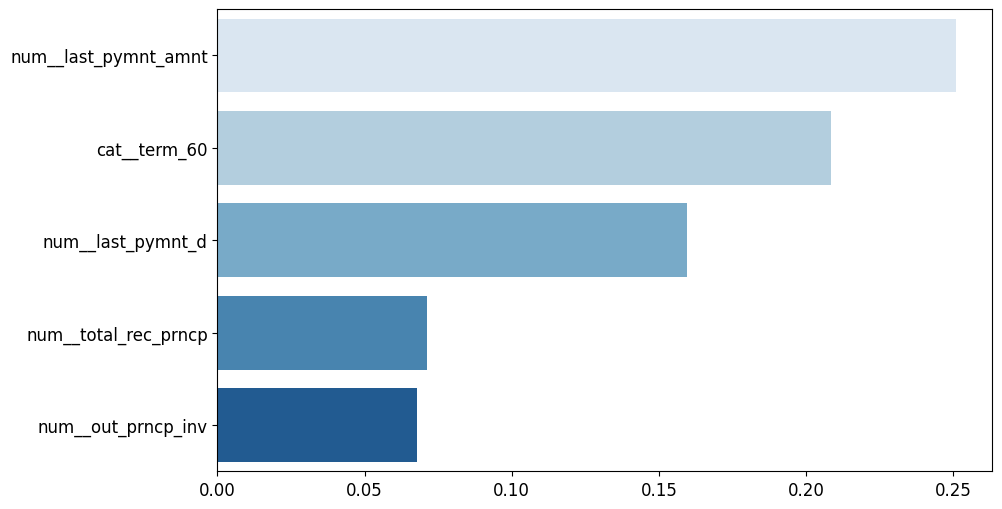

In [ ]:
#Check feature importances for best XGboost model

#best estimator
best_XGb

#Extract the XGBoost model from the best estimator
best_XGb_model = best_XGb.named_steps['xgbclassifier']

#Get feature names after transformation
transformed_feature_names = full_pipeline.get_feature_names_out()

#Get feature importances from best XGb model
feature_importances = best_XGb_model.feature_importances_

#Creating to pair up the feature names from the full pipeline and the feature importances
feature_importance_dict = dict(zip(transformed_feature_names, feature_importances))

#Create a dataframe to hold the results
feature_importances_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances_df

top_5_features = feature_importances_df.head(5)

#Plotting feature importance
blue_palette = sns.color_palette("Blues", n_colors=len(top_5_features))
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_features, x='Importance', y='Feature', palette=blue_palette)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

print('Top 5 Features - Feature Importance')
;

In [ ]:
y_pred = best_XGb.predict(X_test)

Accuracy: 0.987
precision: 0.974
recall: 0.965
f1: 0.969


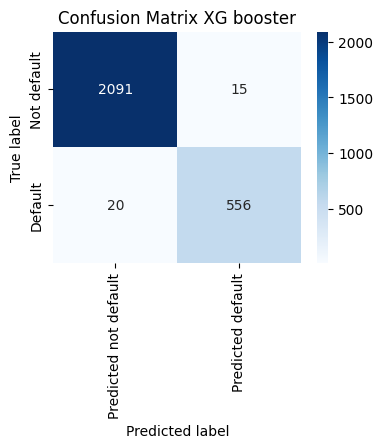

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, roc_curve, roc_auc_score

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'precision: {precision_score(y_test, y_pred):.3f}')
print(f'recall: {recall_score(y_test, y_pred):.3f}')
print(f'f1: {f1_score(y_test, y_pred):.3f}')
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted not default', 'Predicted default'],
            yticklabels=['Not default', 'Default'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix XG booster')
plt.show()

For completness we also tested our Stacking model on the test set:

Accuracy: 0.991
precision: 0.979
recall: 0.977
f1: 0.978


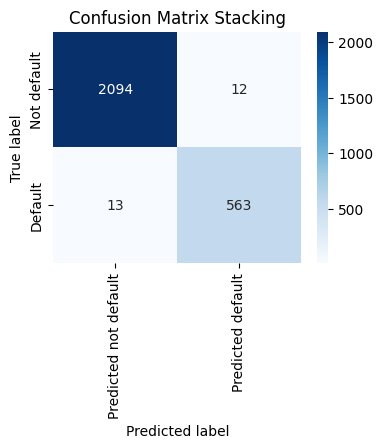

In [ ]:
y_pred_stack = stacking_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_stack):.3f}')
print(f'precision: {precision_score(y_test, y_pred_stack):.3f}')
print(f'recall: {recall_score(y_test, y_pred_stack):.3f}')
print(f'f1: {f1_score(y_test, y_pred_stack):.3f}')
conf_matrix = confusion_matrix(y_test, y_pred_stack)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted not default', 'Predicted default'],
            yticklabels=['Not default', 'Default'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Stacking')
plt.show()

# 8- Appendix

RFECV:

In [ ]:
"""
#Runtime ~ 7min (1% data)
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
rfecv = RFECV(LogisticRegression(max_iter=1000), scoring='f1', cv=3)

rfecv_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', rfecv),
    ('model', LogisticRegression(max_iter=1000))
])

rfecv_pipe.fit(X_train, y_train)
'''

'''
plt.figure(figsize=(10, 6))
plt.title("RFECV - Optimal Number of Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("F1 score")
mean_score = rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(mean_score) + 1), mean_score)

optimal_num_features = rfecv.n_features_
optimal_f1 = rfecv.cv_results_['mean_test_score'][optimal_num_features - 1]
print(f"Optimal number of features: {optimal_num_features}")
print(f"Selected features: {rfecv_pipe['prep'].get_feature_names_out()[rfecv.support_]}")
print(f"F1 at optimal number of features: {optimal_f1}");
"""

'\n#Runtime ~ 7min (1% data)\nfrom sklearn.feature_selection import RFECV\nfrom sklearn.feature_selection import RFE\nrfecv = RFECV(LogisticRegression(max_iter=1000), scoring=\'f1\', cv=3)\n\nrfecv_pipe = Pipeline([\n    (\'prep\', prep_pipeline),\n    (\'select\', rfecv),\n    (\'model\', LogisticRegression(max_iter=1000))\n])\n\nrfecv_pipe.fit(X_train, y_train)\n\'\'\'\n\n\'\'\'\nplt.figure(figsize=(10, 6))\nplt.title("RFECV - Optimal Number of Features")\nplt.xlabel("Number of Features Selected")\nplt.ylabel("F1 score")\nmean_score = rfecv.cv_results_[\'mean_test_score\']\nplt.plot(range(1, len(mean_score) + 1), mean_score)\n\noptimal_num_features = rfecv.n_features_\noptimal_f1 = rfecv.cv_results_[\'mean_test_score\'][optimal_num_features - 1]\nprint(f"Optimal number of features: {optimal_num_features}")\nprint(f"Selected features: {rfecv_pipe[\'prep\'].get_feature_names_out()[rfecv.support_]}")\nprint(f"F1 at optimal number of features: {optimal_f1}");\n'